# Simulating Some Micrographs

This notebook demonstrates how to use TEM-simulator to create synthetic cryoEM images that we can later use to demonstrate the entire reconstruction pipeline. It also provides a mean for us to determine differences between simulated and real data; and also the efficiency of the reconstruction process.

First we import some modules

In [1]:
%matplotlib inline
import os, sys
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('../src/')
import simutils, cryoemio, dataviz

We cheat here, we don't really want to write a simulator in a python notebook, and instead we reference the binary of the simulator we shall use

In [2]:
SIMULATOR_BIN='/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/Simulation/TEM-simulator'

<a id='setup'></a>
# Simulation setup

## Setting parameters

### molecular model

Here we define the actual molecule that we want to simulate imaging. We also need to define the voxel_size that will be used to generate the electrostatic potential map from the molecular model. The resulting map can be written to file if `particle_mrcout` is not None. We might want to give a name to the molecular model/particle.

In [3]:
voxel_size      = 0.1                # [nm]
particle_name   = 'toto'             # Name of the particle. Not very important.
particle_mrcout = None               # volume map of sample is written.

### specimen grid parameters
The solubilized specimen is deposited on a grid with holes that are imaged. Here we define the diameter of the hole and the thickness of the ice layer at the center and edge of the hole.

In [4]:
hole_diameter         = 1200 # [nm]
hole_thickness_center = 100  # [nm]
hole_thickness_edge   = 100  # [nm]

### beam parameters
The microscope electron gun is characterized by the voltage applied to it, its energy spread and the dose received per surface area on the specimen.

In [5]:
voltage           = 300 # [kV]
energy_spread     = 1.3 # [V]
electron_dose     = 100 # [e/nm**2] dose per image
electron_dose_std = 0   # standard deviation of dose per image

### optics parameters

In [6]:
magnification         = 81000 #
spherical_aberration  = 2.7   # [mm]
chromatic_aberration  = 2.7   # [mm]
aperture_diameter     = 50    # [um] in back focal plane
focal_length          = 3.5   # [mm]
aperture_angle        = 0.1   # [mrad] of the condenser lens
defocus               = 1.0   # [um]
defocus_syst_error    = 0.0   #
defocus_nonsyst_error = 0.0   #
optics_defocusout     = None  # file to write defocus values

### detector parameters

In [7]:
detector_Nx           = 5760 # number of pixels along X axis
detector_Ny           = 4092 # number of pixels along Y axis
detector_pixel_size   = 5    # [um]
detector_gain         = 32   # average number of counts per electron
detector_Q_efficiency = 0.5  # detector quantum efficiency
noise                 = 'no' # whether quantized electron waves result in noise
MTF_params            = [0,0,1,0,0] # to be described. [0,0,1,0,0] is perfect detector.

# Simulate data

## Prepare input file

### 0. Input / Outputs

In [8]:
# Inputs
PDB_DIR    = 'material/simple_data/'  # relative path to directory containing candidate PDB fiels
PDB        = '4v6x'                   # ID of PDB file found in pdbdir
MICROGRAPH_KEYWORD = PDB+'_randomrot' # user-specified keyword
# Outputs
OUTPUT_DIR = '/gpfs/slac/cryo/fs1/g/ML/cryoEM-notebooks/data/Simulation/synthetic_datasets/examples/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

### 1. Define the filenames and assemble some input arrays

In [9]:
pdb_file, mrc_file, crd_file, log_file, inp_file, h5_file = cryoemio.simio(PDB_DIR, PDB, OUTPUT_DIR, MICROGRAPH_KEYWORD)
if particle_mrcout is not None:
    particle_mrcout = mrc_file

In [10]:
sample_dimensions = [ hole_diameter, hole_thickness_center, hole_thickness_edge ]
beam_params       = [ voltage, energy_spread, electron_dose, electron_dose_std ]
optics_params     = [ magnification, spherical_aberration, chromatic_aberration, 
                      aperture_diameter, focal_length, aperture_angle,
                      defocus, defocus_syst_error, defocus_nonsyst_error, optics_defocusout ]
detector_params   = [ detector_Nx, detector_Ny, detector_pixel_size, 
                      detector_gain, noise, detector_Q_efficiency,
                      MTF_params[0], MTF_params[1], MTF_params[2], MTF_params[3], MTF_params[4] ]

### 2. Build specimen coordinate file (grid of particles)


The function `define_grid_fov` places copies of the molecular models on a rectangular grid which this time only spans the field of view. The spacing here is explicitely sets to be the maximal dimension of the object (`Dmax`) read from `pdb_file`, to which we add some padding (`pad`). 

In [11]:
x_range, y_range, numpart = simutils.define_grid_in_fov(sample_dimensions, 
                                                        optics_params, 
                                                        detector_params, 
                                                        pdb_file=pdb_file, 
                                                        Dmax=30, pad=5.)

In [12]:
simutils.write_crd_file(numpart, xrange=x_range, yrange=y_range, crd_file=crd_file)

### 3. Build input dictionary

All the information about the experiment that we have prepared so far is stored in a dictionary.

In [13]:
params_dictionary = simutils.fill_parameters_dictionary(mrc_file = mrc_file, 
                                                        pdb_file = pdb_file, 
                                                        particle_mrcout = particle_mrcout, 
                                                        crd_file = crd_file,
                                                        sample_dimensions = sample_dimensions,
                                                        beam_params = beam_params,
                                                        optics_params = optics_params,
                                                        detector_params = detector_params,
                                                        log_file = log_file,
                                                        seed=1234)

### 4. Format dictionary in input file

The content of this dictionary is formatted in a file input to `TEM_simulator`.

In [14]:
simutils.write_inp_file(inp_file=inp_file, dict_params=params_dictionary)

## Run the simulation

Time to image some fake molecule!

In [15]:
os.system('{0} {1}'.format(SIMULATOR_BIN, inp_file))

0

Let's see what we've got! Read the micrograph data from the mrc file generated:

In [16]:
data = cryoemio.mrc2data(mrc_file = mrc_file)
micrograph = data[0,...]

/opt/rh/rh-python36/root/usr/lib/python3.6/site-packages/mrcfile/mrcinterpreter.py:217: RuntimeWarning: Unrecognised machine stamp: 0x44 0x11 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


and display it...

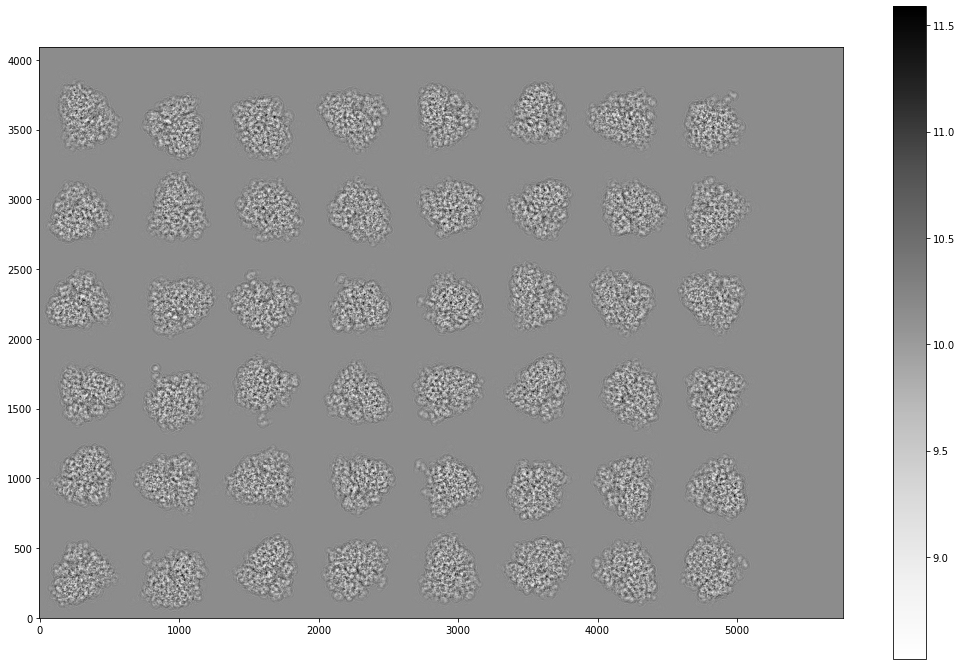

In [19]:
fig = plt.figure(figsize=(18,12))
plt.imshow(micrograph, origin='lower', cmap='Greys')
plt.colorbar()

# Processing the data

### 1. Particle extraction (not quite picking yet)
Here we take advantage of the fact that we placed the molecules ourselves.

In [20]:
particles = simutils.microgaph2particles(micrograph, sample_dimensions, optics_params, detector_params, pdb_file=pdb_file, Dmax=30, pad=5.)

Array dimensions:  (48, 648, 648)


We save the particle stack in a `.hdf5` file:

In [21]:
cryoemio.data_and_dic_2hdf5(particles, h5_file, dic = params_dictionary)

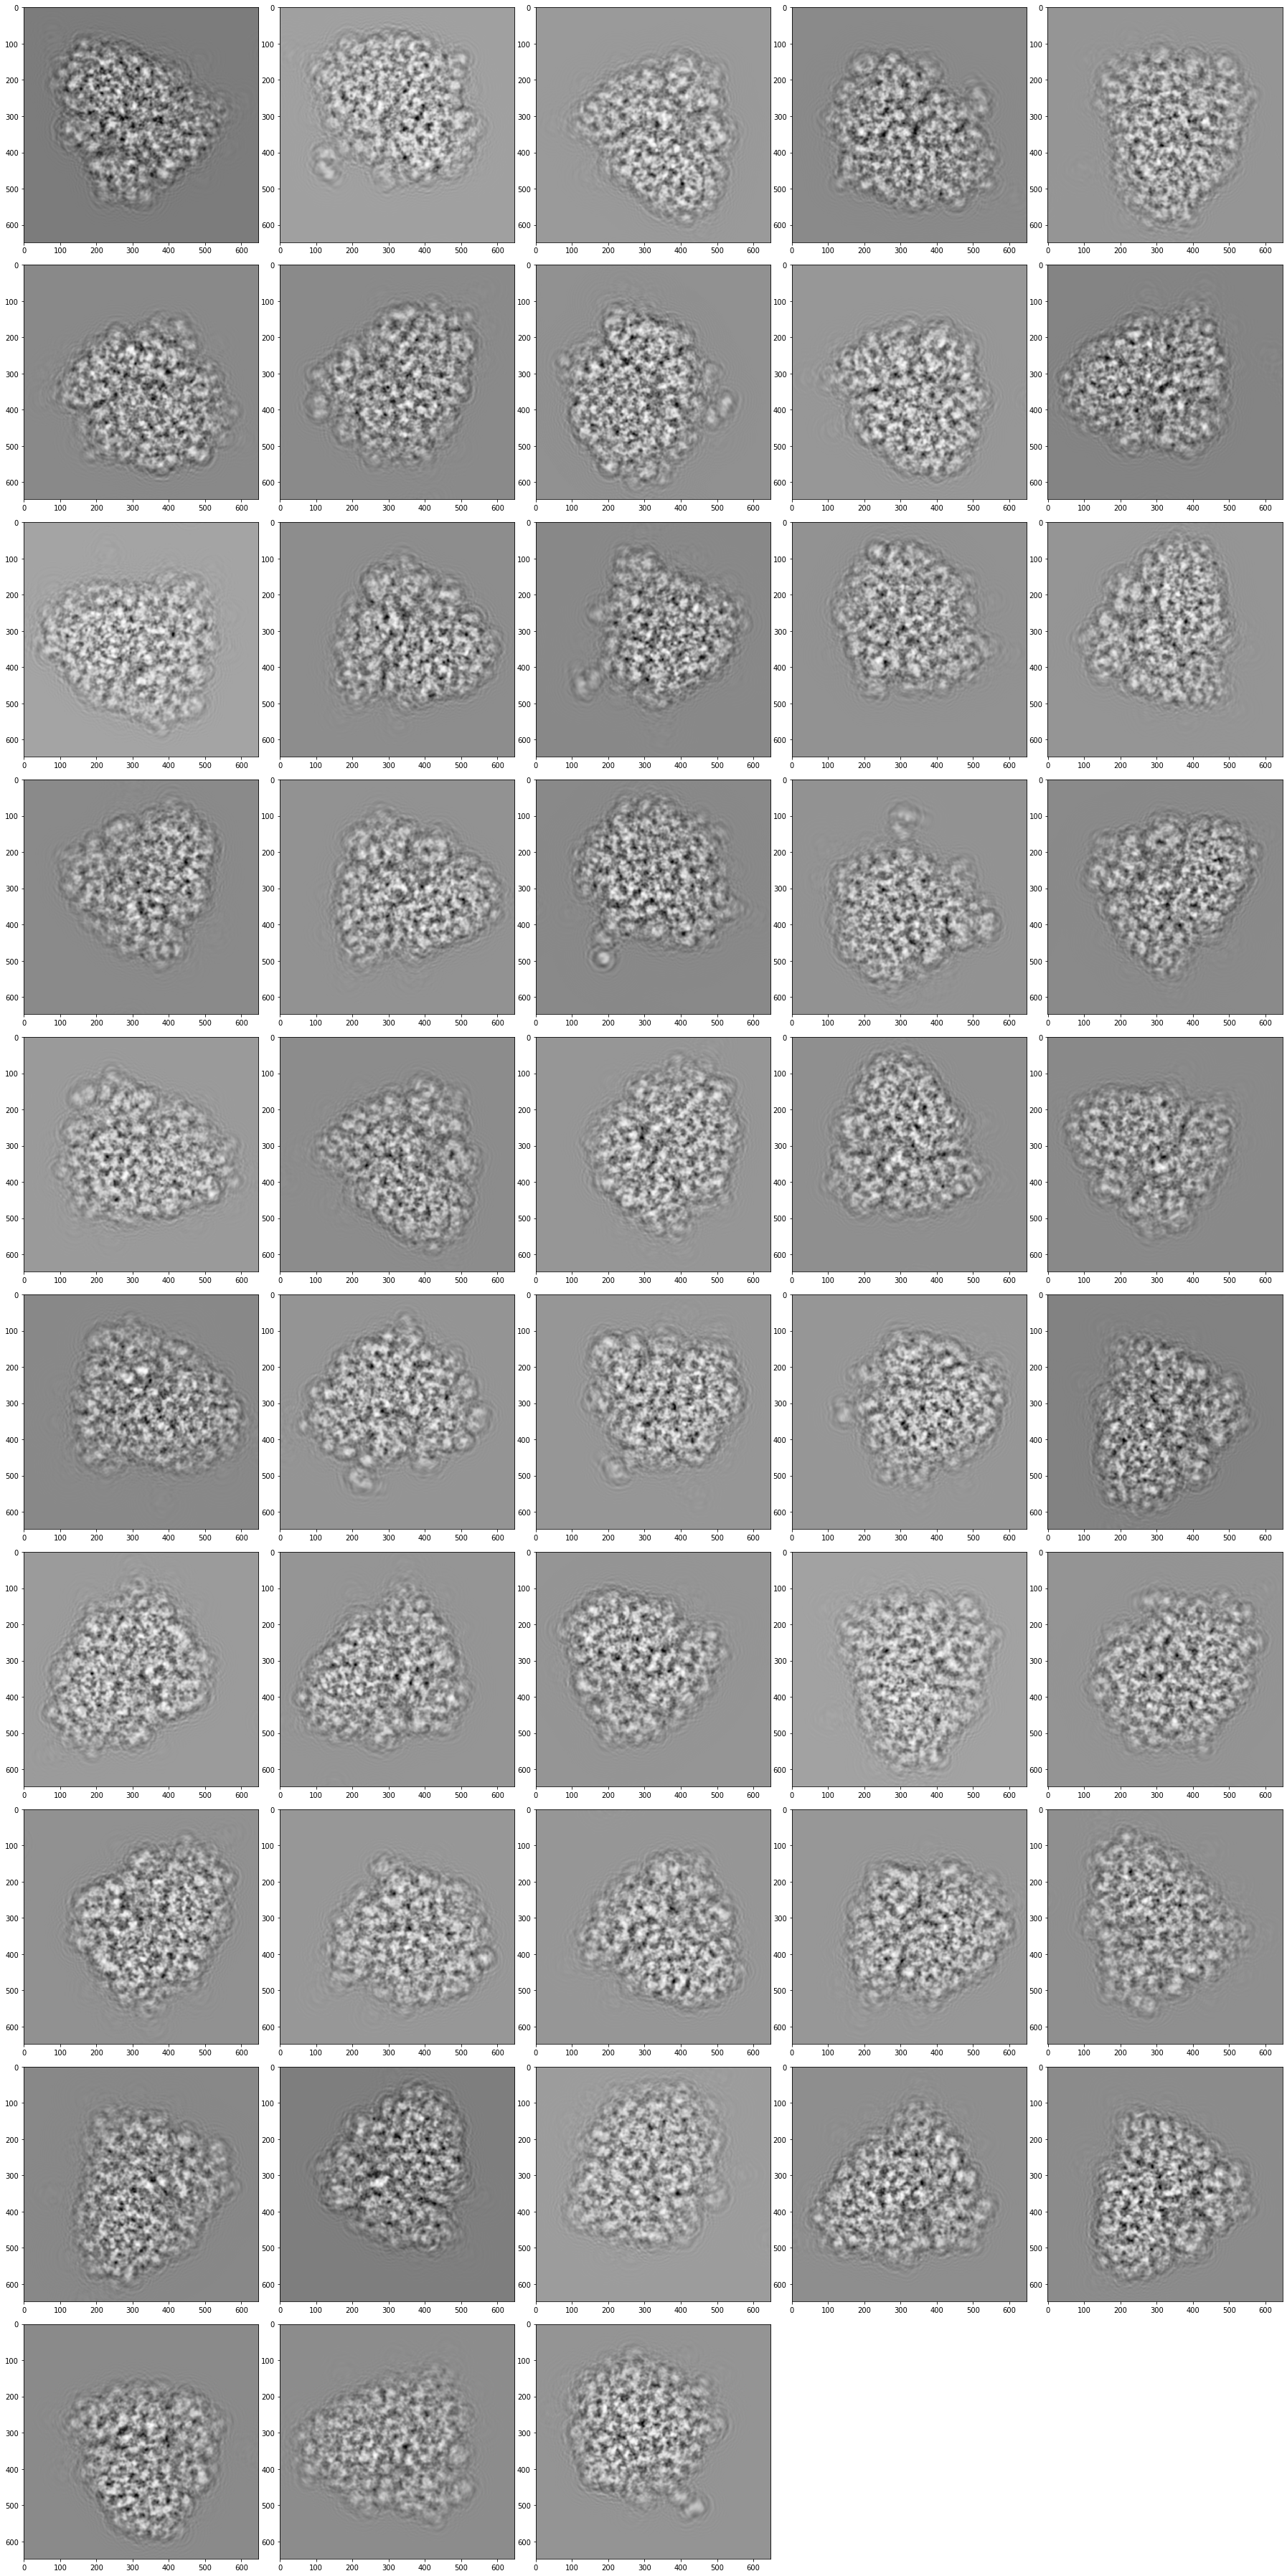

In [22]:
dataviz.view_particles(particles, ncol=5 )

## Added post November 2019

[tweet from Wim Hagen](https://twitter.com/WimJHH/status/1197918044821037058)
```
Details in 4.1:
http://nchrem.nl/wp-content/uploads/2010/04/Titan-condenser-manual.pdf

Gun brightness specification for current Titan Krios is >7.5 x 10^7 A/m^2/sr/V. Direct detectors need between 2 and 15 electrons per pixel per second, then work out I & D (= dose rate). Alpha = simulator aperture angle.
```

The formula reads $I = B ⋅ \pi \alpha^{2} ⋅ (\pi/4) D^{2} ⋅ V_{rel}$

$$
\begin{eqnarray}
    B       &= 7.5.10^{7} A/m^{2}/sr/V \\\nonumber
    V_{rel} &= V.(1+V/V_{0}) \\\nonumber
    V_{0}   &=  2m_{electron}c^{2}/e = 1022kV
\end{eqnarray}
$$

To get $\alpha$ we thus need to estimate $I$ and $D$. 

### Estimate I

Call $K$ the current per pixel (typically 2-15 e/s), and N the number of pixels on the detector. The number of electrons per second that hit the specimen is $I = nKN$, where $n$ is the ratio of the actual image size with the size of the detector.

### Estimate D

To estimate $D$, we can follow two routes:

#### dose rate r

Assuming a dose rate $r$ and a collection time $T$, we have $r/T = I/(\pi/4 D^{2})$.

We get: $\alpha = \sqrt{r / (\pi TBV_{rel})}$.

#### pixel size d

Noting $d^{2}$ the unmagnified detector pixel surface matched to the specimen: $(\pi/4)D^{2} = nNd^{2}$.

We get: $ \alpha = \sqrt{K / (\pi d^{2}BV_{rel})}$


In [13]:
import numpy as np
def get_alpha_d(B=1e7,d=1,V=300,K=10,N=1.6e7):
    """
    B in A/m^2/sr/V
    d in Angstroem
    V in kV
    K in electron per second per pixel
    N the number of detector pixels
    ================================
    I > n.K.N
    D > d.(4.N/pi)**0.5
    -------------------
    alpha = (K/(pi.B.Vr.d**2))**0.5
    """
    # define constants
    e   = 1.602*1e-19 # Coulomb
    A2m = 1e-10       # Angstroem to meter
    # scale
    d *= A2m
    K *= e
    Vrel = V*(1+V/1022) 
    # get aperture angle
    alpha = np.sqrt(K/(np.pi*d*d*B*Vrel))
    # print input with unit
    print('Input:')
    print('B = {} A/m^2/sr/V'.format(B))
    print('d = {} m'.format(d))
    print('V = {} kV'.format(V))
    print('K = {} A per pixel'.format(K))
    print('N = {} detector pixels'.format(N))
    # print I, D and alpha
    print('Output:')
    print('I > {:.02f} nA'.format(1e9*K*N))
    print('D > {:.02f} nm'.format(1e9*np.sqrt(4*N/np.pi)*d))
    print('alpha = {:.03f} mrad'.format(1e3*alpha))
    
def get_alpha_r(B=1e7,K=2,r=100,T=1,V=300,N=1.6e7):
    """
    B in A/m^2/sr/V
    r in e/nm**2
    T in s
    V in kV
    ================================
    -------------------
    alpha = (r/(pi.T.B.Vr))**0.5
    """
    # define constants
    e   = 1.602*1e-19 # Coulomb
    A2m = 1e-10       # Angstroem to meter
    # scale
    K *= e
    r *= e/(A2m*A2m*100)
    Vrel = V*(1+V/1022) 
    # get aperture angle
    alpha = np.sqrt(r/(np.pi*T*B*Vrel))
    # print input with unit
    print('Input:')
    print('B = {} A/m^2/sr/V'.format(B))
    print('r = {} C/m**2'.format(r))
    print('T = {} s'.format(T))
    print('V = {} kV'.format(V))
    # print I, D and alpha
    print('Output:')
    print('I > {:.02f} nA'.format(1e9*K*N))
    print('D > {:.02f} nm'.format(1e9*np.sqrt((4*K*N*T)/(np.pi*r))))
    print('alpha = {:.03f} mrad'.format(1e3*alpha))

In [16]:
help(get_alpha_r)
get_alpha_r(K=2,r=100)

Help on function get_alpha_r in module __main__:

get_alpha_r(B=10000000.0, K=2, r=100, T=1, V=300, N=16000000.0)
    B in A/m^2/sr/V
    r in e/nm**2
    T in s
    V in kV
    -------------------
    alpha = (r/(pi.T.B.Vr))**0.5

Input:
B = 10000000.0 A/m^2/sr/V
r = 16.02 C/m**2
T = 1 s
V = 300 kV
Output:
I > 0.01 nA
D > 638.31 nm
alpha = 0.036 mrad


In [2]:
help(get_alpha_d)
get_alpha_d(K=2,d=0.62)

Help on function get_alpha_d in module __main__:

get_alpha_d(B=10000000.0, d=1, V=300, K=10, N=16000000.0)
    B in A/m^2/sr/V
    d in Angstroem
    V in kV
    K in electron per second per pixel
    N the number of detector pixels
    I > n.K.N
    D > d.(4.N/pi)**0.5
    -------------------
    alpha = (K/(pi.B.Vr.d**2))**0.5

Input:
B = 10000000.0 A/m^2/sr/V
d = 6.2e-11 m
V = 300 kV
K = 3.204e-19 A per pixel
N = 16000000.0 detector pixels
Output:
I > 0.01 nA
D > 279.84 nm
alpha = 0.083 mrad
